In [1]:
import sys
sys.path.append('../')
from utility.file_utility import FileUtility
from scipy.sparse import csr_matrix
from shutil import copyfile



In [210]:
fasta_files, mapping = FileUtility.read_fasta_directory('../../../datasets/deepbio/microbiome/RA/', 'fastq')


In [ ]:
for cpe in sampling_dict.keys():
    for N in sampling_dict[cpe]:
        print('cpe',cpe, ' with sampling size ', N)
        RS = Metagenomic16SRepresentation(fasta_files, mapping, N, num_p)
        # path to save the generated files
        RS.generate_cpes_all(cpe_file, cpe , save=out_dir + '_'.join([dataset_name, str(cpe), 'cpe', str(N)]))

In [2]:
labeler=dict([tuple(x.split(',')) for x in FileUtility.load_list('../../bio_cpe_datacollection/representations/RA/grouping.csv')[1::]])

In [3]:
SRX2row=dict([(x.split('/')[-1].split('.')[0],idx) for idx, x in enumerate(FileUtility.load_list('../../bio_cpe_datacollection/representations/RA/RA_100000_cpe_10000_meta'))])

In [5]:
FileUtility.save_list('RA_lables.txt',['\t'.join([x,y]) for x,y in labeler.items()])

## Bootstrapping

In [40]:
from bootstrapping.bootstrapping import BootStrapping


In [42]:
BT=BootStrapping('a','b','c')
BT.load('../../16S_datasets/ra/boot/results_bootstrapping_synthetic.pickle')
BT.plotting_cpe('Arthiris','Arthiris',ylimv=100,ratio=100)

## Marker finding

In [4]:
from taxonomic_assignment.Seq2Tax import Seq2Tax
def get_matrix_label(X, labeler, SRX2row, pos=[], neg=[]):
    label_vec=[]
    X=X.toarray()
    New_X=[]
    for srx,label in labeler.items():
        if label in pos:
            New_X.append(X[SRX2row[srx],:])
            label_vec.append(1)
        elif label in neg:
            New_X.append(X[SRX2row[srx],:])
            label_vec.append(0)
    return csr_matrix(New_X), label_vec

In [22]:
mat=FileUtility.load_sparse_csr('../../16S_datasets/ra/rep/ra_selfposcpe_50000_cpe_-1.npz')
features=FileUtility.load_list('../../16S_datasets/ra/rep/ra_selfposcpe_50000_cpe_-1_features')
X,labels=get_matrix_label(mat, labeler, SRX2row, pos=['healthy'], neg=['treated_RA','untreated_RA'])
SeqTaxa=Seq2Tax()
SeqTaxa.extract_markers('/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/ra/markers/H_vs_tr&ut',X,labels,features)

/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:619: RuntimeWarning: invalid value encountered in less_equal
  np.arange(1, n_features + 1)]
/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


In [13]:
X.shape

(98, 49927)

In [27]:
a='TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTT\nGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCTGTTGAGGCAGGCG\nGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATC'
#b='tacggaggatccgagcgttatccggatttattgggtttaaagggagcgtagatggatgtttaagtcagttgtgaaagtttgcggctcaaccgtaaaattgcagttgatactggatatcctgagtgcagttgaggcaggcggaattcgtggtgtagcggtgaaatgcttagatatc'
print(a.lower())

tacggaggatccgagcgttatccggatttattgggtttaaagggagcgtagatggatgtttaagtcagtt
gtgaaagtttgcggctcaaccgtaaaattgcagttgatactggatatcttgagtgctgttgaggcaggcg
gaattcgtggtgtagcggtgaaatgcttagatatc


In [44]:
import numpy as np
import scipy

rep=np.array([x.split()[1::] for x in FileUtility.load_list('../../16S_datasets/ra/otu/otutab.txt')[1::]], dtype=np.float32).T


In [29]:
def get_matrix_label(X, labeler, SRX2row, pos=[], neg=[]):
    label_vec=[]
    X=X.toarray()
    New_X=[]
    for srx,label in labeler.items():
        if label in pos:
            New_X.append(X[SRX2row[srx],:])
            label_vec.append(1)
        elif label in neg:
            New_X.append(X[SRX2row[srx],:])
            label_vec.append(0)
    return csr_matrix(New_X), label_vec

(114, 949)

In [46]:
X,Y=get_matrix_label(csr_matrix(rep), labeler,SRX2row, pos=['untreated_RA'] , neg=['treated_RA','healthy','psoriatic'])

In [42]:
rows=([x for x in FileUtility.load_list('../../16S_datasets/ra/otu/otutab.txt')[0].split()][2::])

In [43]:
SRX2row={srx:idx for idx,srx in enumerate(rows)}

In [47]:
FileUtility.save_sparse_csr('../../16S_datasets/ra/repkmer/ra_otu',X)

In [49]:
FileUtility.save_obj('../../16S_datasets/ra/repkmer/ra_otu_label',Y)

# Taxonomy matrix

In [107]:
import os
import tqdm

path = '/mounts/data/proj/asgari/dissertation/datasets/deepbio/taxonomy/ncbi-blast-2.5.0+/bin/'
os.environ['PATH'] += ':'+path
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

def is_not_too_ambiguous(results):
    levels_id={'Superkingdom':1,'phylum':1,'class':2,'order':3,'family':4,'genus':5,'species':6}
    
    species=set([x[0][levels_id['species']] for x in results])
    genuses=set([x[0][levels_id['genus']] for x in results])
    families=set([x[0][levels_id['family']] for x in results])
    orders=set([x[0][levels_id['order']] for x in results])
    classes=set([x[0][levels_id['class']] for x in results])
    phylums=set([x[0][levels_id['phylum']] for x in results])
    Superkingdoms=set([x[0][levels_id['Superkingdom']] for x in results])
    
    if len(species)==1:
        return ';'.join(results[0][0])
    elif len(genuses)==1:
        return ';'.join(results[0][0][0:6])
    elif len(families)==1:
        return ';'.join(results[0][0][0:5])
    if len(orders)==1:
        return ';'.join(results[0][0][0:4])
    elif len(classes)==1:
        return ';'.join(results[0][0][0:3]) 
    elif len(phylums)==1:
        return ';'.join(results[0][0][0:2]) 
    elif len(Superkingdoms)==1:
        return ';'.join(results[0][0][0:1]) 
    else:
        return False



In [134]:

seq_IDS=FileUtility.read_fasta_sequences_ids('/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/ra/markers/unt_healthy_chi2_relative.fasta')
ez_taxa_dict={x.split()[0]:x.split()[1].split(';') for x in FileUtility.load_list('/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/EZ/raw/eztaxon_id_taxonomy.txt')}

final_results=[]
for idx, (seq, description) in tqdm.tqdm(seq_IDS.items()):
    pval=float(description.split(':')[1])
    if pval<=0.01:
        FileUtility.create_fasta_file('temp.fasta',[seq],['temp'])
        blastx_cline=NcbiblastnCommandline(query='temp.fasta', db="/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/EZ/raw/eztaxon_qiime_full.fasta", evalue=0.001, outfmt=5, out="temp.xml")
        blastx_cline()
        f=open("temp.xml",'r')
        blast_records = NCBIXML.parse(f)
        flag=False
        score=-1
        alignment_length=-1
        results=[]
        for blast_record in blast_records:
            for alignment in blast_record.alignments:
                for hsp in alignment.hsps:
                    if not flag and score==-1:
                        score=hsp.score
                        alignment_length=hsp.align_length
                        flag=True
                    if hsp.score >= score and hsp.align_length>=alignment_length:
                        results.append((ez_taxa_dict[alignment.hit_id],hsp.expect))
        if len(results)>0:
            res=is_not_too_ambiguous(results)
            if res:
                final_results.append((seq,res+idx[-1],pval))
        else:
            final_results.append((seq,'ZZZNOVEL'+idx[-1],pval))
    

100%|██████████| 1335/1335 [01:18<00:00, 16.94it/s]


351

In [142]:
dictionary_of_taxa=dict()

for x,y,pvalue in final_results:
    if y[0:8]=='ZZZNOVEL':
        dictionary_of_taxa[y+x]=[pvalue]
    else:
        if y not in dictionary_of_taxa:
            dictionary_of_taxa[y]=[]
        dictionary_of_taxa[y].append(pvalue)

dictionary_of_taxa_pvalue=dict()
for x,y in dictionary_of_taxa.items():
    dictionary_of_taxa_pvalue[x]=(len(y),np.mean(y),np.median(y))
    
sorted_taxa=sorted(dictionary_of_taxa_pvalue.items(), key=operator.itemgetter(0), reverse=False)


In [212]:
len(sorted_taxa)

77

In [144]:
import pandas as pd

table = {'taxonomy': [], 'correlation': [], 'number-of-markers':[],'mean-chi2-pvalue':[],'median-chi2-pvalue':[]}
for tax, (num, mu, med) in  sorted_taxa:
    table['taxonomy'].append(tax[0:-1])
    table['correlation'].append(tax[-1])
    table['number-of-markers'].append(num)
    table['mean-chi2-pvalue'].append(mu)
    table['median-chi2-pvalue'].append(med)
df=pd.DataFrame(data=table,columns=['correlation','number-of-markers', 'taxonomy','mean-chi2-pvalue','median-chi2-pvalue'])
df.sort_values(by=['taxonomy'])
writer = pd.ExcelWriter('RA_markers_significant.xlsx')
df.to_excel(writer,'markers')
    

In [103]:
import nltk
from nltk import FreqDist

In [104]:
taxonmies=[y for x,y,pvalue in final_results]

In [105]:
FreqDist(taxonmies).most_common()

[('Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Prevotellaceae;Prevotella+',
  351),
 ('Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides-',
  45),
 ('Bacteria;Firmicutes;Negativicutes;Acidaminococcales;Acidaminococcaceae;Phascolarctobacterium;Phascolarctobacterium_faecium-',
  43),
 ('Bacteria;Firmicutes;Erysipelotrichi;Erysipelotrichales;Erysipelotrichaceae;Catenibacterium;Catenibacterium_mitsuokai+',
  38),
 ('Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Prevotellaceae;Prevotella;EU778070_s+',
  31),
 ('Eukarya;Streptophyta;eudicotyledons;core_eudicotyledons;Oleaceae;Jasminum;Jasminum_nudiflorum+',
  27),
 ('Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Prevotellaceae;Prevotella;EU462041_s+',
  23),
 ('Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae-', 16),
 ('Bacteria;Firmicutes;Negativicutes;Veillonellales;Veillonellaceae;Dialister;AF371694_s+',
  14),
 ('Bacteria;Tenericutes;Mollicutes;Acholeplasmatales;Acholeplasmataceae;Acholepl

In [213]:
import operator
import numpy as np
from utility.list_set_util import argsort
import matplotlib
import matplotlib.pyplot as plt
from utility.visualization_utility import create_mat_plot
%pylab inline
%matplotlib inline 

sorted_features=sorted(final_results, key=operator.itemgetter(1), reverse=False)


Populating the interactive namespace from numpy and matplotlib


/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['argsort']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [179]:
taxonomis=[x[1] for x in sorted_features]

In [214]:
sorted_features[0]

('tgctgcctcccgtaggagtttggaccgtgtctcagttccaatgtggggggaccttcctctcagaacccctactgatcgtagccttgg',
 'Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales+',
 0.0080044984714)

In [99]:
taxonmies.count('ZZZNOVEL')

7

In [215]:
rep=FileUtility.load_sparse_csr('../../16S_datasets/ra/rep/ra_unique_50000_cpe_-1.npz')
features=FileUtility.load_list('../../16S_datasets/ra/rep/ra_unique_50000_cpe_-1_features')

new_matrix=[]
for feature, taxnomy, pvalue in sorted_features:
    column=features.index(feature)
    new_matrix.append(rep[:,column].toarray().T[0].tolist())
new_matrix=np.array(new_matrix)

In [216]:
new_matrix.shape

(351, 114)

In [217]:
labels=FileUtility.load_list('../../16S_datasets/ra/rep/labels.txt')

In [218]:
labels_idx=argsort(labels)

In [219]:
sorted_labels=[labels[idx] for idx in labels_idx]

In [220]:
new_matrix=new_matrix[:,labels_idx]

In [228]:
from utility.math_utility import normalize_mat
new_matrix=normalize_mat(new_matrix,axis=0)*100

In [229]:
import seaborn as sns; sns.set()
def create_mat_plot(mat, axis_x, axis_y, title, filename, xlab, ylab, cmap='inferno', filetype='pdf', rx=0, ry=0, font_s=10, annot=True):
    '''
    :param mat: divergence matrix
    :param axis_names: axis_names
    :param title
    :param filename: where to be saved
    :return:
    '''
    #plt.rc('text', usetex=True)
    
    ax = sns.heatmap(mat,annot=annot, cmap=cmap,fmt="d")
    plt.title(title)
    params = {
        'legend.fontsize': font_s,
        'xtick.labelsize': font_s,
        'ytick.labelsize': font_s,
        #'text.usetex': True,
    }
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
    matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(rotation=rx)
    plt.yticks(rotation=ry)
    plt.rcParams.update(params)
    plt.tight_layout()
    plt.savefig(filename + '.'+filetype)
    plt.show()
    plt.clf()


In [ ]:
def seriation(Z,N,cur_index):
    '''
        got the code from: https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        got the code from: https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [230]:
def get_borders(mylist):
    val=0
    borders=[]
    for i,v in enumerate(mylist):
        if i==0:
            val=v
        else:
            if not v==val:
                borders.append(i)
                val=v
    return borders

In [231]:
get_borders([1,2,2,3,3,3,4,4])

[1, 3, 6]

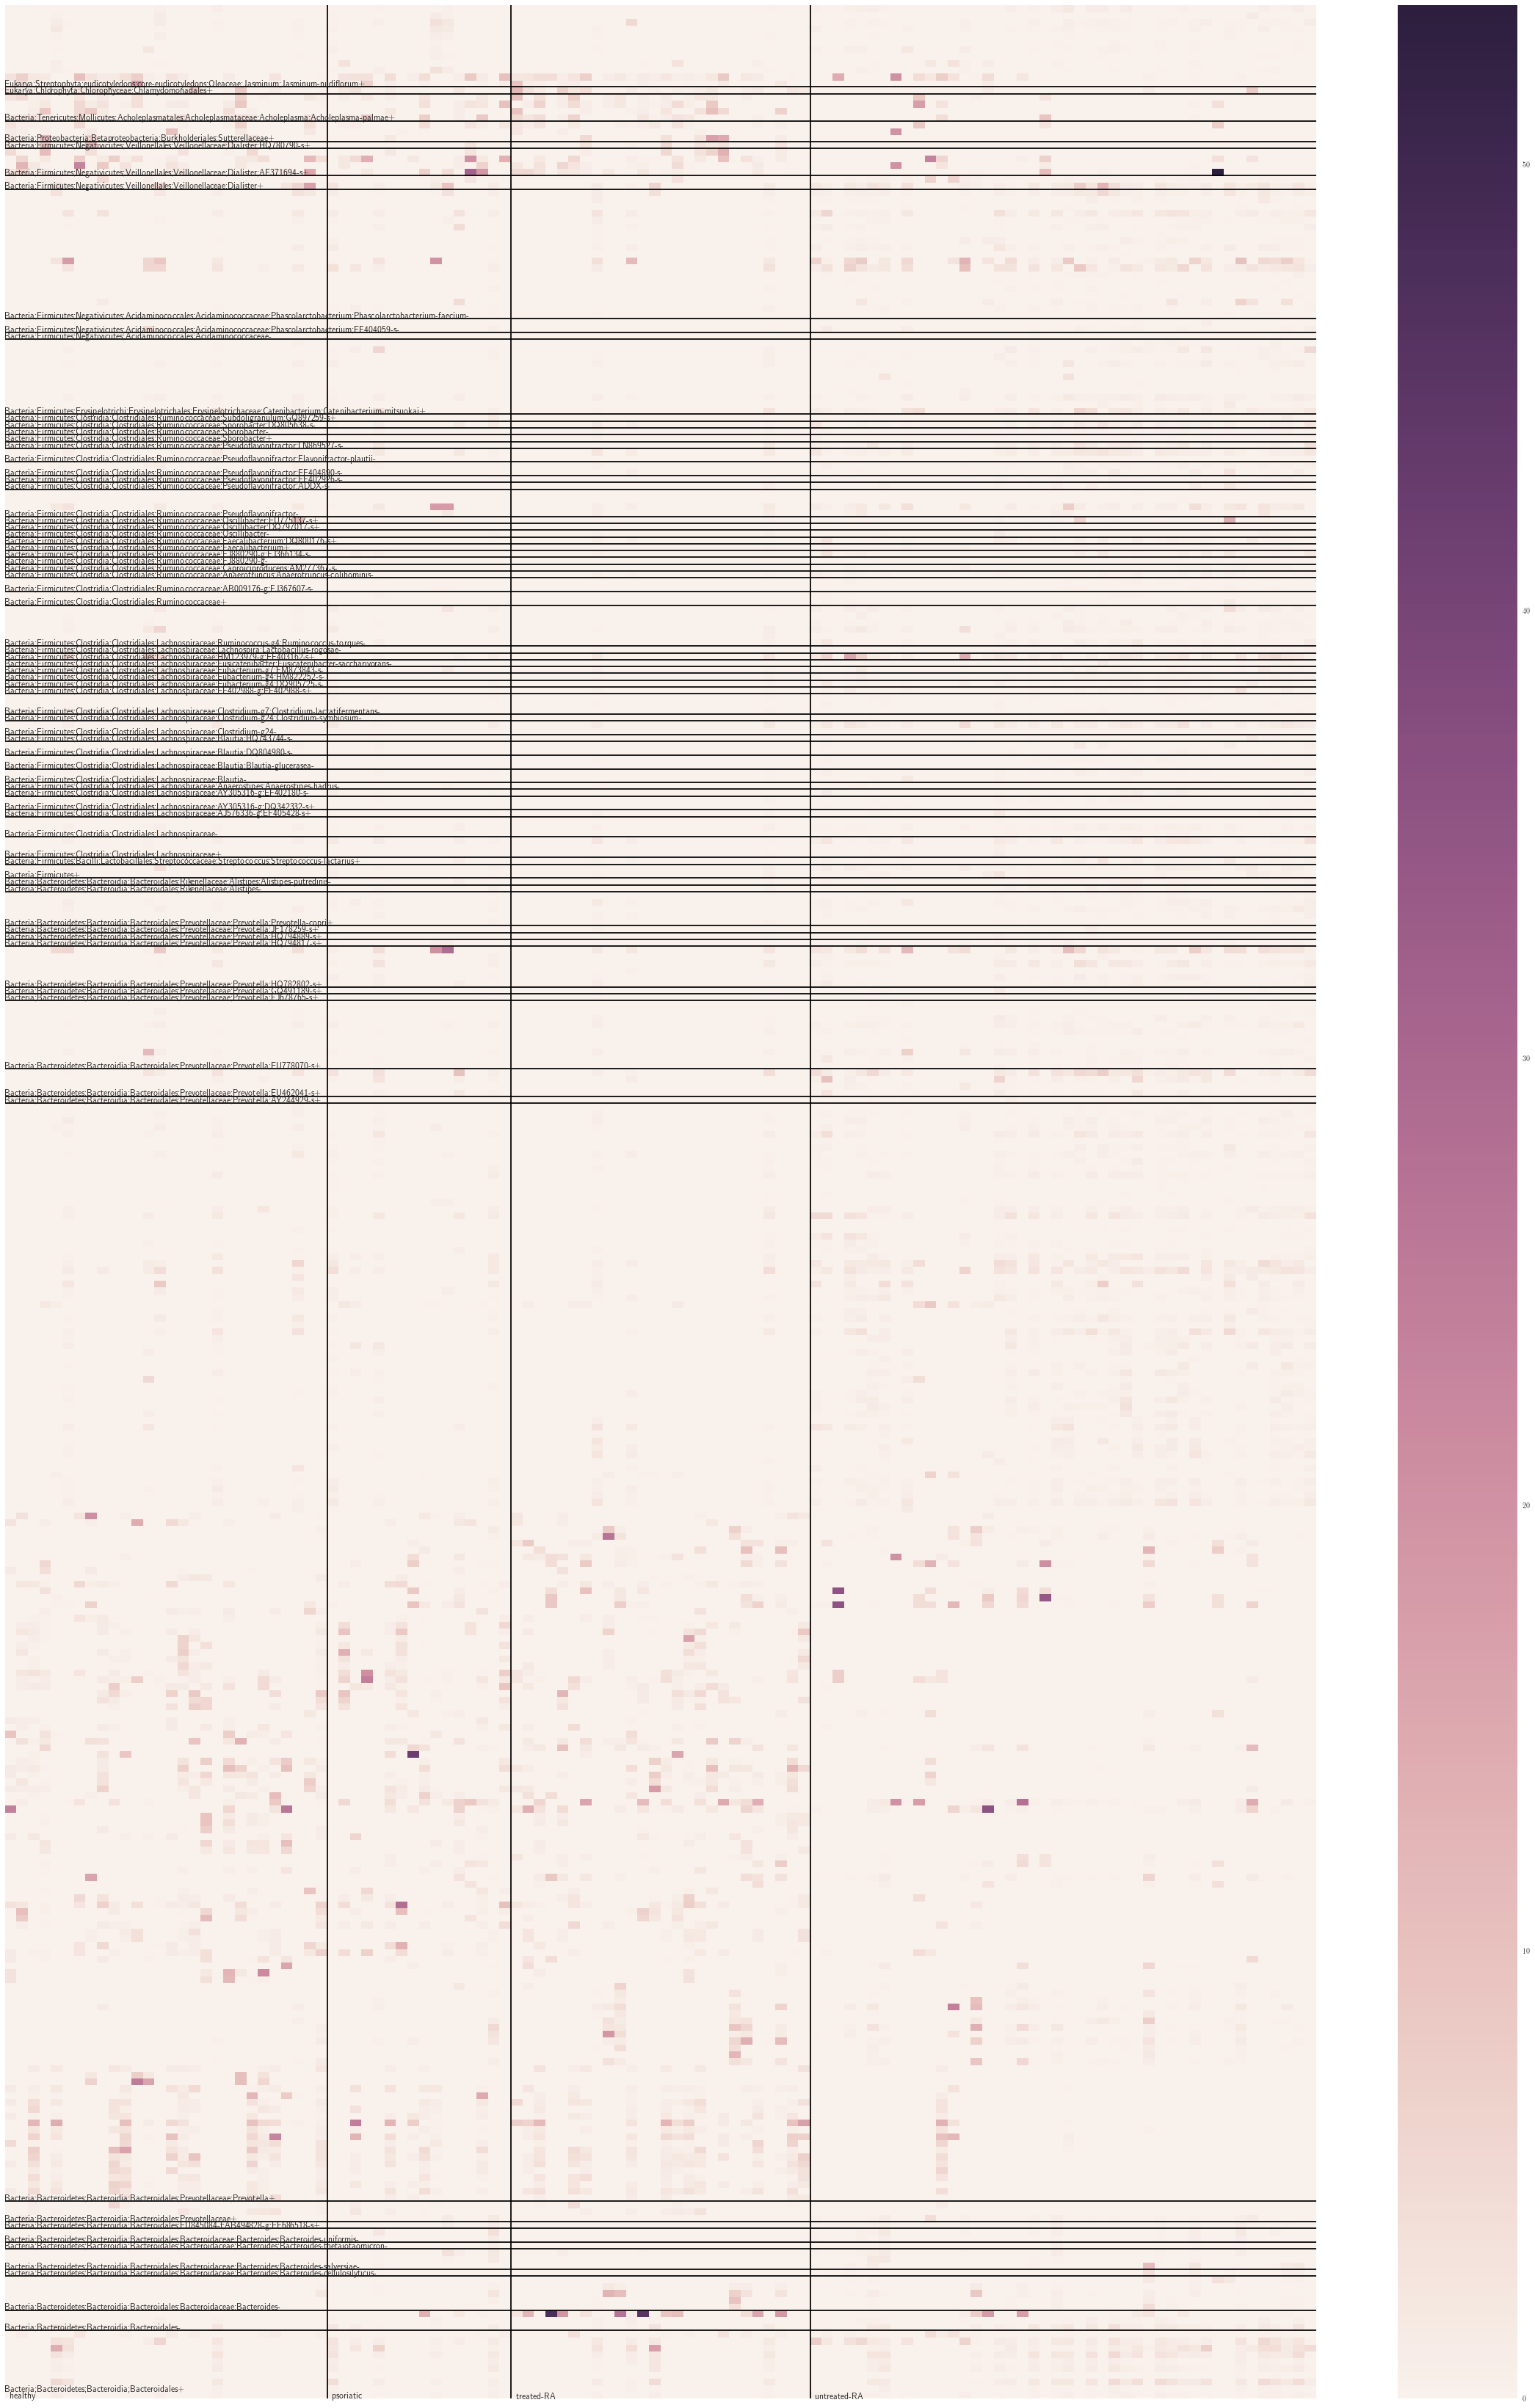

In [232]:
import seaborn as sns; sns.set()
fig, ax = plt.subplots(figsize=(40,60)) 
sns.heatmap(new_matrix, cbar=True, ax=ax)
ax.hlines(get_borders(taxonomis), *ax.get_xlim())

ax.vlines(get_borders(sorted_labels), *ax.get_ylim(), label=['h','s','t','u'])

plt.text(0.4,0,sorted_labels[0].replace('_','-'))
for x in get_borders(sorted_labels):
    plt.text(x+0.4,0,sorted_labels[x].replace('_','-'))

plt.text(0,1,taxonomis[0].replace('_','-'), rotation=0)
for x in get_borders(taxonomis):
    plt.text(0,x,taxonomis[x].replace('_','-'), rotation=0)

ax.grid(True)
plt.xticks([])
plt.yticks([])
plt.savefig('RA_markers.pdf', dpi=600 )
plt.show()

#plt.imshow(new_matrix, cmap='hot', interpolation='nearest')


In [201]:
import os
import tqdm

path = '/mounts/data/proj/asgari/dissertation/libraries/graphlan/'
os.environ['PATH'] += ':'+path
#export PATH=/mounts/data/proj/asgari/dissertation/libraries/graphlan/:$PATH


In [207]:
#sage: graphlan.py [-h] [--format ['output_image_format']]
#                  [--warnings WARNINGS] [--positions POSITIONS]
#                  [--dpi image_dpi] [--size image_size] [--pad pad_in]
#                  [--external_legends] [--avoid_reordering] [-v]
#                  input_tree output_image
